<a target="_blank" href="https://colab.research.google.com/github/davalpez/MyKaggle/blob/master/Tensorflow%20basics/NLP-Project-Simplify.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# NLP Project : Simplify

This is a project that is part of the Tensorflow Deep Learning bootcamp from Udemy.

**Overview**

The objective of this project is to create a NLP model that transforms convoluted written abstract into an easier readable format.

The data user will be taken from this source:
https://arxiv.org/abs/1710.06071
The model used in this project will be based on:
https://arxiv.org/pdf/1612.05251

**Index guide for the notebook**

1. Notebook setup
2. Fetch dataset
3. Create preprocess functions
4. Draft model experimentation
5. Multimodal model creation
6. Visualize predictions
7. Test model

## Notebook Setup

As we have done before, we will first import our own library file where we store functions introduced in other notebooks to continue more efficiently.

In [4]:
import sys
import os

sys.path.append(os.path.abspath("../lib"))

In [5]:
import importlib
import modelgraph  # Import the module
importlib.reload(modelgraph)  # Reload it after changes

<module 'modelgraph' from '/home/david/VSpython/Git/lib/modelgraph.py'>

In [6]:
!nvidia-smi

Thu Feb 27 23:16:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.51                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2070 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   68C    P0             18W /   80W |     303MiB /   8192MiB |     28%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
import tensorflow as tf
tf.config.set_soft_device_placement(True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [9]:
!export TF_GPU_ALLOCATOR=cuda_malloc_async

## Fetch the data

The data we will use is fetched from the this [pubmed-rct repository](https://github.com/Franck-Dernoncourt/pubmed-rct).

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git ../Sources/pubmed-rct  
!ls ../Sources/pubmed-rct  

Cloning into '../Sources/pubmed-rct'...

PubMed_200k_RCT  
PubMed_200k_RCT_numbers_replaced_with_at_sign  
PubMed_20k_RCT  
PubMed_20k_RCT_numbers_replaced_with_at_sign  
README.md

Checking the content of the file, we have :
* `PubMed 20k` as a lite version of the `PubMed 200k`.
* `PubMed 200k` as the main file containing the abstracts.
*  Copies of `PubMed 200k` and `PubMed 20k` where numbers had been replaced with the `@` symbol.

We will start using the `PubMed 20k replaced with at sign` dataset, as it will be a good representation to train and test our models and figure out what model works best with this type of data. As we progress with our experiments, we can later scale to the `PubMed 200k replaced with at sign`.

In [10]:

# Check what files are in the PubMed_20K dataset 
!ls ../Sources/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


We can see how we already have the dataset separated into train and test files. We also have dev file, which is another way of naming the validation file.

In [11]:
def ReadLinesFromFile(file_path):
    """
    Reads lines from a file and returns them as a list.

    Args:
    file_path (str): The path to the file to be read.

    Returns:
    list: A list of strings, each representing a line from the file.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return lines

In [12]:

train_path = '../Sources/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt'
train_raw_data_20k = ReadLinesFromFile(train_path)
train_raw_data_20k[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's also take a look to the test and validation data

In [13]:

test_path = '../Sources/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt'
test_raw_data_20k = ReadLinesFromFile(test_path)
test_raw_data_20k[:20]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [14]:
val_path = '../Sources/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt'
val_raw_data_20k = ReadLinesFromFile(val_path)
val_raw_data_20k[:10]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
 'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
 'RESULTS\tSixty-five patients were randomized .

The way the data is structured in this file is :

* A hashtag line indicating a new abstract `###`
* A `ID number` for an specific abstract.
* A `type` for the content of every line.
* A `text`that indentifies with the content of every line.
* An `ES`after every line.

How it would be interesting to format this data into a dictionary per abstract.

1. Line number we are refering from an specific abstract.
2. Specify the type of text.
3. Displaying the text content
4. Total lines.
5. Abstract ID, so we can see and compare the results better after.

In [15]:
def GenerateAbstractSamples(raw_data):
    """
    Generates a prcoessed sampled dataset from a raw dataset. The function takes in a variable
    raw dataset and returns a list of dictionaries, where each dictionary represents an abstract
    sample.

    Args:
    dataset (list): A list of strings, each representing a line from the dataset file.

    Returns:
    list: A list of abstracts, where each abstract is represented as a list of dictionaries. 
          Each dictionary contains the following keys:
          - 'type': The type of the line (e.g., BACKGROUND, METHODS, RESULTS, CONCLUSIONS).
          - 'text': The text content of the line.
          - 'line_number': The line number within the abstract.
          - 'total_lines': The total number of lines in the abstract.
          - 'abstract_id': The ID of the abstract.
    """
    abstracts = []
    current_abstract = None
    line_count = 0
    abstract_id = None

    for line in raw_data:
        if line.startswith('###'):
            if current_abstract:
                for entry in current_abstract:
                    entry['total_lines'] = line_count
                    entry['abstract_id'] = abstract_id
                abstracts.append(current_abstract)
            current_abstract = []
            line_count = 0
            abstract_id = line.strip()[3:]  # Extract the abstract ID
        elif line.strip():
            line_count += 1
            parts = line.split('\t')
            if len(parts) == 2:
                type_, text = parts
                current_abstract.append({
                    'type': type_,
                    'text': text.strip(),
                    'line_number': line_count,
                    'total_lines': 0,  # This will be updated later
                    'abstract_id': abstract_id  # This will be updated later
                })

    if current_abstract:
        for entry in current_abstract:
            entry['total_lines'] = line_count
            entry['abstract_id'] = abstract_id
        abstracts.append(current_abstract)

    return abstracts

# Generate abstracts from the test dataset
train_samples_20k = GenerateAbstractSamples(train_raw_data_20k)
train_samples_20k[:2]  # Print the first 2 abstracts for verification

[[{'type': 'OBJECTIVE',
   'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
   'line_number': 1,
   'total_lines': 12,
   'abstract_id': '24293578'},
  {'type': 'METHODS',
   'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
   'line_number': 2,
   'total_lines': 12,
   'abstract_id': '24293578'},
  {'type': 'METHODS',
   'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
   'line_number': 3,
   'total_lines': 12,
   'abstract_id': '24293578'},
  {'type': 'METHODS',
   'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
   'line_number': 4,
   'total_lin

It is looking good now as we have the data now properly organizded and in a format that is easier to extract. We can also transform it into a pandas dataframe for better visualization.

In [16]:
test_samples_20k = GenerateAbstractSamples(test_raw_data_20k)
val_samples_20k = GenerateAbstractSamples(val_raw_data_20k)

In [17]:
len(train_samples_20k), len(val_samples_20k), len(test_samples_20k)

(15000, 2500, 2500)

In [18]:
import pandas as pd

def CreateSampleDf(Samples):
    # Create a dataframe for each sample in Samples
    sample_dfs = [pd.DataFrame(sample) for sample in Samples]

    # Combine all the dataframes into a single dataframe
    combined_df = pd.concat(sample_dfs, ignore_index=True)
    return combined_df

In [19]:
train_df_20k = CreateSampleDf(train_samples_20k)
val_df_20k = CreateSampleDf(val_samples_20k)
test_df_20k = CreateSampleDf(test_samples_20k)

In [20]:
train_df_20k.head(16)

,type,text,line_number,total_lines,abstract_id
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,1,12,24293578
1,METHODS,A total of @ patients with primary knee OA wer...,2,12,24293578
2,METHODS,Outcome measures included pain reduction and i...,3,12,24293578
3,METHODS,Pain was assessed using the visual analog pain...,4,12,24293578
4,METHODS,Secondary outcome measures included the Wester...,5,12,24293578
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",6,12,24293578
6,RESULTS,There was a clinically relevant reduction in t...,7,12,24293578
7,RESULTS,The mean difference between treatment arms ( @...,8,12,24293578
8,RESULTS,"Further , there was a clinically relevant redu...",9,12,24293578
9,RESULTS,These differences remained significant at @ we...,10,12,24293578


We can see now in this dataframe we have all the abstracts together and we can see the separation by seeing the change in the `abstract_id` or `total_lines` changing. We could create a dataframe where we have each sample saved as well, but we have decided to go this way for now to visualize some metrics better as we are showing in the following cells:

In [21]:

# Distribution of labels in training data
train_df_20k.type.value_counts()

type
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

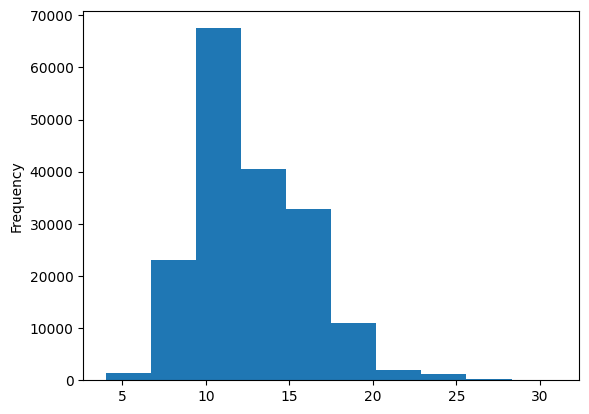

In [22]:
train_df_20k.total_lines.plot.hist()

In [23]:
train_df_20k.total_lines.mean()

np.float64(12.789135747611642)

We can see that most of the content on each asbtract is shared between `methods` and `results` and that the average of total lines is 12.78, while most of them are allocated between 7 and 15 in a normal distribution.

## Create preprocess functions

Now, we need to turn this data into a data that our model can process and understand. For this purpose, we will use one hot encoding and encoded labels.

In [24]:

# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df_20k["type"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df_20k["type"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df_20k["type"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Now we transform the one-hot to label encoded. 

In [25]:
from sklearn.preprocessing import LabelEncoder

# Encode labels for train, validation, and test datasets

label_encoder = LabelEncoder()

# Encode labels for training data
train_labels_encoded = label_encoder.fit_transform(train_df_20k["type"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df_20k["type"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df_20k["type"].to_numpy())

# Check the encoded labels
train_labels_encoded[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

And we can have the direct assigment to the classes.

In [26]:

# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names
     

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

We will also save the text to a string list as this is what we will fit into our model.

In [27]:
# Convert abstract text lines into lists 
train_sentences = train_df_20k["text"].tolist()
val_sentences = val_df_20k["text"].tolist()
test_sentences = test_df_20k["text"].tolist()

For creating an embedding layer later on for dense models, we need to still prepare some part of the data. We checked what is the average number of sentences for minding what lenght we want to use in our model and if we want to use padding. But we also need to analyze the amount of words we have per sentence.

In [28]:
import numpy as np
train_sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
avg_train_sentence_length = np.mean(train_sentence_lengths)
avg_train_sentence_length

np.float64(26.338269273494777)

Taking a view of how the data is distributed

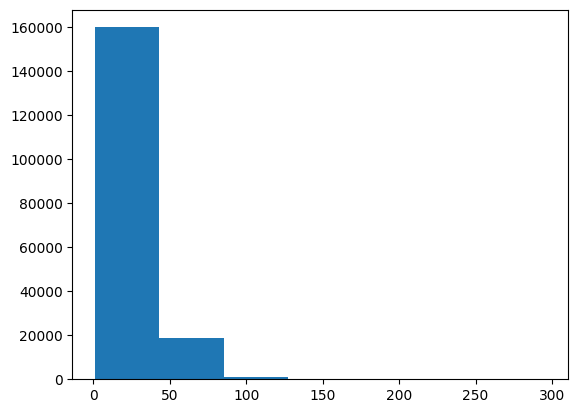

In [29]:
import matplotlib.pyplot as plt
plt.hist(train_sentence_lengths, bins=7);

If we want to see how many tokens would need the 95% of our sentences...

In [30]:

# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(train_sentence_lengths, 95))
output_seq_len
     

55

And just to have an idea of what are some outliers here:

In [73]:
max(train_sentence_lengths),min(train_sentence_lengths)

(296, 1)

## Draft Model Experimentation

We are ready to start doing our experiments as our data has been preprocessed. We will draft a plan as we have done before to know where will we start and how we will try to experiment and improve through different models.

 **Model iteration**      | **Model description**                                                                 |
|--------------------------|---------------------------------------------------------------------------------|
| **model_0**          | Model based on Naive Bayes |
| **model_1**      |  NN with dense layers (dense model) |
| **model_2**      | LSTM model  |
| **model_3**      | GRU model  |
| **model_4**      | Bidirectional LTSM model   |
| **model_5**      | 1D Convolutional Neural Network   |
| **model_6**      | Transfer learning model   |

### Model 0 : Baseline model based on Naive Bayes

Our baseline model will be a the TF-IDF Multinomial Naive Bayes model. As we did in our previous TF-NLP.ipynb, this is a simple model but that can be quite effective for simple task. Let's see how it performs here.

In [74]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

We can already see how our model will classify the sentences from the validation set.

In [75]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

For a baseline model, it is quite a good results to achieve 72.18% accuracy. 7 out of 10 sentences will be categorized correctly from any abstract we read, and we can improve this results with more complex models in the future.

To keep track of our progress, we can calculate the scores of this model and each model in the future and do comparisons to see what model will perform best for this task.

In [76]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [77]:
baseline_results = modelgraph.calculate_results(y_true=val_labels_encoded, 
                                    y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 1: Conv1d

In order to build our first CNN for working on this NLP model, we need to start creating the first layers that will proccess our inputs (the text sentences) converting them into tokens and and add a group value for each sentence through our embedding layer.

### Creating text vectorizarion for the dense models 

From the [PubMed200k RCT paper](https://arxiv.org/pdf/1710.06071), we can see that the PubMed20K raw data has 68.000 words and the 200k has 311.000 words. So for this model we can declare that maximum amount of tokens will be 68k for our [text vectorizer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).

As we checked before, the average sentence lenght is 26 but we will go for a 55 expected sentence lenght as the 95% of our data will have that lenght( and we don't want to lose valuable information from the abstracts).

In [31]:
from tensorflow.keras.layers import TextVectorization

max_tokens = 68000
expected_sentence_lenght = 55

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=expected_sentence_lenght) # desired output length of vectorized sequences
     

I0000 00:00:1740691032.413866    1947 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


Now that we have created our text_vectorizer, we need to pass it our text data so we have values assigned to our tokens.

In [32]:

# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

We can take a look to an example and see how some sentence now has been converted to an specific token.

In [33]:

# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
Planned interim analysis using the O'Brien-Fleming boundary was crossed for improvement in OS .

Length of text: 14

Vectorized text:
[[ 1362  2426    85    59     2 29644 10060    10  3950    11   194     5
    653     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


We can see this sentence has the expected average lenght. As we still need to be wary of longer sentences, we have the expectetation of 55 words(tokens), so we count with padding to fill the unused spaces.

Let's check from our text vectorizer what are the most and least commont words.

In [34]:
rct_20k_vocab = text_vectorizer.get_vocabulary()
rct_20k_vocab = [str(word) for word in rct_20k_vocab]
print(f"Words in vocabulary: {len(rct_20k_vocab)}")
print(f"Most common words : {rct_20k_vocab[:5]}")
print(f"Least common words : {rct_20k_vocab[-5:]}")

Words in vocabulary: 64841
Most common words : ['', '[UNK]', 'the', 'and', 'of']
Least common words : ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [82]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create the embedding layer for this specific model

Now that we created our text vectorizer, we need to create the [embedding layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) so we can provide some relations between the numbers we are feeding into our model.

As our model learns, the embedding layer will be updated and so, the relation concept that our embedding layer has between the tokens will evolve in time.

In [83]:
from tensorflow.keras.layers import Embedding
# Create token embedding layer
embedding_layer_0 = Embedding(input_dim=len(rct_20k_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="embedding_layer_0") 

If we want to see an example : 

In [84]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = embedding_layer_0(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
Reproducible associations were also observed for eSNPs in @ additional genes : fatty acid desaturase @ ( FADS@ ; P = @ ) , N-acetyl -- D-galactosaminidase ( NAGA ; P = @ ) , and Factor XIII , A@ ( F@A@ ; P = @ ) .

Sentence after vectorization (before embedding):
[[ 7791   992     9   138   148    11 23203     5   365  1847  1105   386
  59920 31356    14  9367 59838 36658    14     3   432 41709     8  2723
     14     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.03645419  0.01443664  0.03296283 ... -0.02740195  0.01821331
   -0.02045984]
  [-0.00371559  0.0009904   0.00690639 ... -0.01459949  0.005814
    0.02610642]
  [-0.03514116 -0.01385161 -0.01242412 ...  0.0301263   0.02216018
    0.03929644]
  ...
  [-0.02119676 -0.0453065  -0.01408998 ... -0.02054691 -0.00967202
   -0.04784808]


### Creating the dataset for our dense model

We have created our dataframes before with pandas and have organized our data. We can still make it easier for our model to process this data with the [tf.data API](https://www.tensorflow.org/guide/data). 

Choosing this method to prepare our data will take advantage of GPU usage and prepare the input pipeline [faster](https://www.tensorflow.org/guide/data_performance).

In [35]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

### Creating and training the model

Now that we have our input processing layers created, our model is ready to be built.

The structure we want to follow for the model is:
 1. **Input** layer that will receive text.
 2. **Tokenization** of the text.
 3. **Embedding** process to stablish numerical relations.
 4. **Grouped convoluted layers** to process and classify the relations.
 5. **Ouput probability** for each sentence, determining the class of each sentence.

So let's start creating now our Convoluted 1 Dimension model.

In [54]:
# Set random seed for weight initialization.
tf.random.set_seed(10)

# 1. Create the model.

from tensorflow.keras.layers import Input,Conv1D,GlobalAveragePooling1D,Dense,LSTM
from tensorflow.keras import Model

# Create 1D convolutional model to process sequences
inputs = Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = embedding_layer_0(text_vectors) # create embedding
#x = LSTM(32, return_sequences=True)(token_embeddings) # condense the output of our feature vector
x = Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

/home/david/VSpython/tf-gpu-env/lib/python3.12/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [55]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer_0 (Embedding)   │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

We have quite a big amount of training parameters for our embedding layer if we take a look at the summary of our first convolution model.

As we have also a large dataset (15k training samples, 2.5k of test and 2.5k of validation samples), so just to have an idea of how good the model could perform, we can use a 10% of the dataset to see how good the performance can be, we will take just a sub-set from it.

It is a good practice to test the model on a small dataset and scale up as we progress in our experiments. 10% of the data is good, as long as we cover a good distribution of our data.

In [56]:
# 2. Compile the model
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [57]:
# 3. Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches
     

Epoch 1/3


I0000 00:00:1740663002.636247    4606 cuda_dnn.cc:529] Loaded cuDNN version 90300


562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.5106 - loss: 1.1782 - val_accuracy: 0.7354 - val_loss: 0.6900
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7439 - loss: 0.6902 - val_accuracy: 0.7653 - val_loss: 0.6418
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7666 - loss: 0.6283 - val_accuracy: 0.7829 - val_loss: 0.6037


### Evaluating Model 1

Training the model didn't take too long in the end and we have achieved a good accuracy. Let's make some predictions and see what score we achieve with this model.

In [58]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7831 - loss: 0.6028


[0.6050218939781189, 0.7823381423950195]

In [59]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


array([[4.1262600e-01, 1.8684800e-01, 9.0394348e-02, 2.7791914e-01,
        3.2212533e-02],
       [4.2741761e-01, 3.1738889e-01, 1.0916462e-02, 2.3580822e-01,
        8.4688431e-03],
       [1.9138981e-01, 7.3439963e-03, 2.7835551e-03, 7.9845357e-01,
        2.9113093e-05],
       ...,
       [6.0392158e-06, 9.0391317e-04, 7.7856408e-04, 3.3982094e-06,
        9.9830806e-01],
       [3.7093561e-02, 4.4656178e-01, 8.0750965e-02, 4.0239897e-02,
        3.9535385e-01],
       [1.5520661e-01, 6.4159220e-01, 6.0008924e-02, 5.3801619e-02,
        8.9390531e-02]], dtype=float32)

In [60]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [61]:

# Calculate model_1 results
model_1_results = modelgraph.calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.2338143783927,
 'precision': 0.7782297800149067,
 'recall': 0.782338143783927,
 'f1': 0.7792336725259496}

In [62]:
modelgraph.CompareModelScores(baseline_results, model_1_results)

Baseline accuracy: 72.18, New accuracy: 78.23, Difference: 6.05
Baseline precision: 0.72, New precision: 0.78, Difference: 0.06
Baseline recall: 0.72, New recall: 0.78, Difference: 0.06
Baseline f1: 0.70, New f1: 0.78, Difference: 0.08


Let's jump into the next model now

## Model 2 : Model 1, adding a LSTM layer

This model doesn't need much explanation. We will use a LSTM layer as it is recommended to save some information from the embedding layer before passing it into the convolutional 1D layer.

In [78]:
# Create token embedding layer
embedding_layer_1 = Embedding(input_dim=len(rct_20k_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=False,
                               name="embedding_layer_1") 


In [79]:
# Set random seed for weight initialization.
tf.random.set_seed(10)

# 1. Create the model.
from tensorflow.keras.layers import Bidirectional

# Create 1D convolutional model to process sequences
inputs = Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = embedding_layer_1(text_vectors) # create embedding
x = Bidirectional(LSTM(32, return_sequences=True))(token_embeddings)  # CuDNN-enabledx = Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
x = GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs)

In [80]:
model_2.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer_1 (Embedding)   │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 55, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,341,189 (31.82 MB)

 Trainable params: 8,341,189 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 2. Compile the model
model_2.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 3. Fit the model
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3


562/562 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.5131 - loss: 1.1674 - val_accuracy: 0.7031 - val_loss: 0.7564
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.7107 - loss: 0.7613 - val_accuracy: 0.7340 - val_loss: 0.6935
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - accuracy: 0.7293 - loss: 0.6910 - val_accuracy: 0.7613 - val_loss: 0.6347


### Evaluating model 2

In [83]:
# Make predictions (our model outputs prediction probabilities for each class)
model_2_pred_probs = model_2.predict(valid_dataset)

# Convert pred probs to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds


# Calculate model_2
model_2_results = modelgraph.calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

  1/945 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step

945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step


{'accuracy': 76.64504170528267,
 'precision': 0.7650154308829152,
 'recall': 0.7664504170528267,
 'f1': 0.763943424945686}

In [84]:
modelgraph.CompareModelScores(model_1_results,model_2_results)

Baseline accuracy: 78.23, New accuracy: 76.65, Difference: -1.59
Baseline precision: 0.78, New precision: 0.77, Difference: -0.01
Baseline recall: 0.78, New recall: 0.77, Difference: -0.02
Baseline f1: 0.78, New f1: 0.76, Difference: -0.02


Seems adding a Bidirectional LSTM did not have a great impact.

## Model 3 : feature extraction layer

For this model, we are going to use a model that replicates the architecture used in [Neural Netowrks for Joint Sentence classification](https://arxiv.org/pdf/1612.05251), which is the [GloVe](https://nlp.stanford.edu/projects/glove/) (Global Vectors for Word Representation)

For our experiment, we can try to use transfer-learning model as a way of emulating this paper's approach. 

We will instead use a pretrain embedding (Universal Sentence Encoder) and then build our model on top of that.

In [36]:
import tensorflow_hub as hub

print("TF Version: " + tf.__version__)
print("TF Hub version " + hub.__version__)

TF Version: 2.18.0
TF Hub version 0.16.1


In [37]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Load the path for the model we want.
uni_encoder_path = "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2"

In [10]:
# Load the path for the model we want.
uni_encoder_path = "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2"
embed = hub.load(uni_encoder_path)

I0000 00:00:1740671029.045769   11957 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


In [49]:
import random

# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = embed([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
Furthermore , the patients were measured concerning weight and waist and hip circumference .

Sentence after embedding:
[-0.02885863  0.05677564 -0.04198207  0.02804436  0.02845938 -0.0440783
 -0.0575275   0.00180711 -0.01355083 -0.01458261  0.06209934 -0.01638985
 -0.0483803   0.06436092 -0.06140358 -0.00061076 -0.07922433  0.02606871
 -0.0662067   0.03277857  0.01203264  0.06532329  0.04292666  0.00482687
  0.05076363  0.03274849  0.05714659  0.01979816  0.03962671  0.0129372 ] (truncated output)...

Length of sentence embedding:
512


The only issue we have when using Tensorflow_hub is that we need to ensure that the `hub.KerasLayer` is properly used within the Keras model. The error occurs because the `hub.KerasLayer` expects a TensorFlow tensor, not a Keras tensor. That is why in this case we wrap  the `hub.KerasLayer` in a custom Keras layer.

The downside of following this procedure is that we can't see the full trainable parameters we are having this layer.

This is due to having Tensorflow 2.18 installed that deals with Keras 3 models. This provokes some incompatiblities between keras and tensorflow. The problem of rolling back to 2.15 where these issues don't exist relay on the rest of the function from tensorflow that have been updated to improve better overall efficiency from this library.

In [39]:
tf_hub_embedding_layer = hub.KerasLayer(uni_encoder_path,
                                        trainable=False,
                                        name="universal_sentence_encoder")

NameError: name 'uni_encoder_path' is not defined

In [40]:
import tf_keras as keras
import tensorflow as tf

model_3 = keras.Sequential([
    tf_hub_embedding_layer,                         
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
], name="model_3")


In [47]:
import tf_keras as keras
version_fn = getattr(tf.keras, 'version', None)
print('TF Version: ' + tf.__version__)
print('TF keras version ' + keras.__version__)
print('TF Keras Version: ' + version_fn())
print('TF Hub version ' + hub.__version__)

TF Version: 2.18.0
TF keras version 2.18.0
TF Keras Version: 3.8.0
TF Hub version 0.16.1


In [45]:
print('TF keras version ' + keras.__version__)

TF keras version 2.18.0


In [4]:
import tensorflow_hub as hub
import tensorflow as tf
from tf_keras import layers
import tf_keras as keras

# Set random seed for weight initialization.
keras.utils.set_random_seed(10)

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

# 1.Create the model
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embeddings = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embeddings)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = keras.Model(inputs, outputs,name="model_3")



TypeError: 'float' object cannot be interpreted as an integer

In [78]:
# 2.Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [79]:
model_3.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [80]:
model_3_history = model_3.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3


/home/david/VSpython/tf-gpu-env/lib/python3.12/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


TypeError: in user code:

    File "/home/david/VSpython/tf-gpu-env/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/home/david/VSpython/tf-gpu-env/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1381, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/david/VSpython/tf-gpu-env/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1370, in run_step  **
        outputs = model.train_step(data)
    File "/home/david/VSpython/tf-gpu-env/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1147, in train_step
        y_pred = self(x, training=True)
    File "/home/david/VSpython/tf-gpu-env/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/lib/python3.12/random.py", line 336, in randint
        return self.randrange(a, b+1)
    File "/usr/lib/python3.12/random.py", line 312, in randrange
        istop = _index(stop)

    TypeError: Exception encountered when calling layer 'model_3' (type Sequential).
    
    'float' object cannot be interpreted as an integer
    
    Call arguments received by layer 'model_3' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=True
      • mask=None
